# Emotion Detection

**Importing Libraries**

In [1]:
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os
import scipy
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization,Activation,MaxPooling2D
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG,Image
import tensorflow as tf
print("Tensorflow version:",tf.__version__)

Tensorflow version: 2.13.0


**Exploring Dataset**

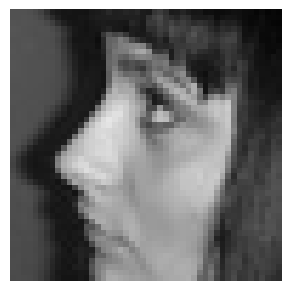

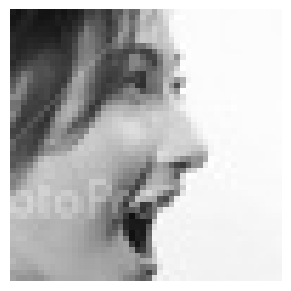

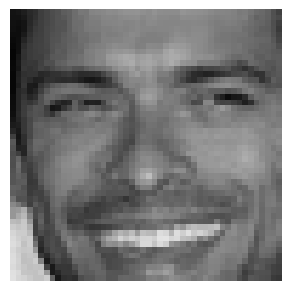

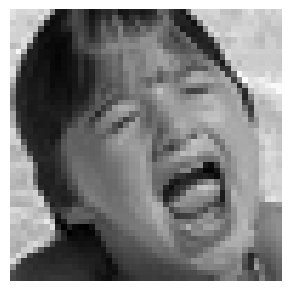

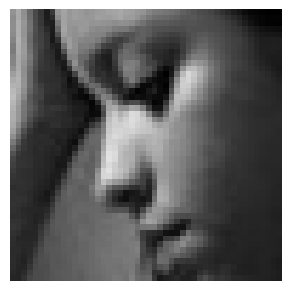

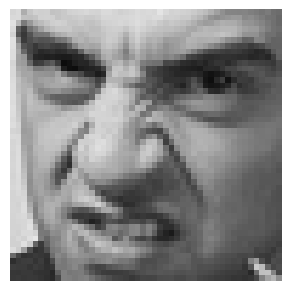

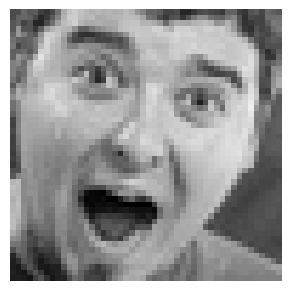

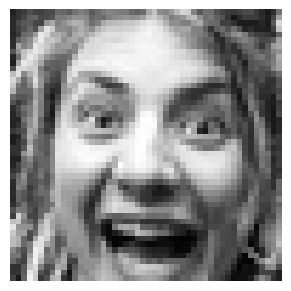

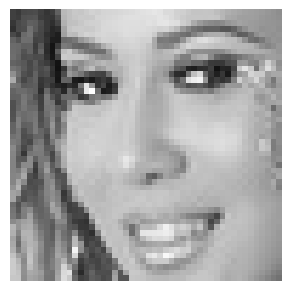

In [2]:
images=glob("Train/**/**")
for i in range(9):
    image=random.choice(images)
    plt.figure(figsize=(12,12))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(image));plt.axis('off')

**Preparing Data for Training**

In [3]:
img_size=48
batch_size=64
datagen_train=ImageDataGenerator()
train_generator=datagen_train.flow_from_directory("train/", target_size=(img_size,img_size), color_mode="grayscale",
                                                  batch_size=batch_size, class_mode="categorical", shuffle=True)
validation_generator=datagen_train.flow_from_directory("test/", target_size=(img_size,img_size), color_mode="grayscale",
                                                  batch_size=batch_size, class_mode="categorical", shuffle=True)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


**DEFINING MODEL**

In [4]:
def convolution(input_tensor,filters,kernel_size):
    x=Conv2D(filters=filters,kernel_size=kernel_size,padding="same")(input_tensor)
    x=BatchNormalization()(x)
    x=Activation('relu')(x)
    x=MaxPooling2D(pool_size=(2,2))(x)
    x=Dropout(0.25)(x)

    return x

In [5]:
def Dense_f(input_tensor,nodes):
    x=Dense(nodes)(input_tensor)
    x=BatchNormalization()(x)
    x=Activation('relu')(x)
    x=Dropout(0.25)(x)

    return x

In [6]:
def model_fer(input_shape):
    inputs=Input(input_shape)
    conv_1=convolution(inputs,32,(3,3))
    conv_2=convolution(inputs,64,(5,5))
    conv_3=convolution(inputs,128,(7,7))

    flatten=Flatten()(conv_3)

    dense_1=Dense_f(flatten,256)

    output=Dense(7,activation="softmax")(dense_1) #7 is no. of classes
    model=Model(inputs=[inputs],outputs=[output])

    model.compile(loss=['categorical_crossentropy'],optimizer='adam',metrics=['accuracy'])

    return model

In [7]:
model=model_fer((48,48,1))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 128)       6400      
                                                                 
 batch_normalization_2 (Bat  (None, 48, 48, 128)       512       
 chNormalization)                                                
                                                                 
 activation_2 (Activation)   (None, 48, 48, 128)       0         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 24, 24, 128)       0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 24, 24, 128)       0     

**INITIALIZING THE MODEL**

In [8]:
epochs=15
steps_per_epoch=train_generator.n//train_generator.batch_size
validation_steps=validation_generator.n//validation_generator.batch_size

checkpoint=ModelCheckpoint("model_weights.h5",monitor='val_accuracy',save_weights_only=True,mode='max',verbode=1)
callbacks=[checkpoint]

**TRAINING THE MODEL**

In [9]:
history=model.fit(x=train_generator,
                  steps_per_epoch=steps_per_epoch,
                  epochs=epochs,
                  validation_data=validation_generator,
                  validation_steps=validation_steps,
                  callbacks=callbacks)

Epoch 1/15
448/448 [==============================] - 688s 2s/step - loss: 1.6874 - accuracy: 0.3549 - val_loss: 1.6052 - val_accuracy: 0.3750
Epoch 2/15
448/448 [==============================] - 195s 436ms/step - loss: 1.4070 - accuracy: 0.4604 - val_loss: 1.5912 - val_accuracy: 0.3770
Epoch 3/15
448/448 [==============================] - 186s 415ms/step - loss: 1.2583 - accuracy: 0.5248 - val_loss: 1.7760 - val_accuracy: 0.2910
Epoch 4/15
448/448 [==============================] - 182s 406ms/step - loss: 1.1463 - accuracy: 0.5740 - val_loss: 1.4836 - val_accuracy: 0.4464
Epoch 5/15
448/448 [==============================] - 180s 402ms/step - loss: 1.0427 - accuracy: 0.6128 - val_loss: 1.5024 - val_accuracy: 0.4362
Epoch 6/15
448/448 [==============================] - 183s 408ms/step - loss: 0.9321 - accuracy: 0.6567 - val_loss: 1.8974 - val_accuracy: 0.3287
Epoch 7/15
448/448 [==============================] - 178s 398ms/step - loss: 0.8265 - accuracy: 0.7008 - val_loss: 1.6010 - va

**MODEL EVALUATION**

In [11]:
model.evaluate(validation_generator)

113/113 [==============================] - 143s 1s/step - loss: 2.0486 - accuracy: 0.4483


[2.048647403717041, 0.44831427931785583]

**Plotting Losss**

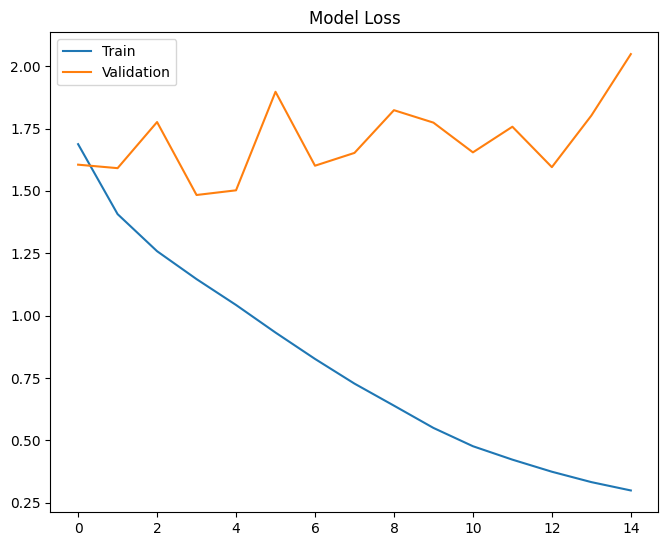

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train','Validation'],loc='upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0.0,hspace=0.25,wspace=0.35)

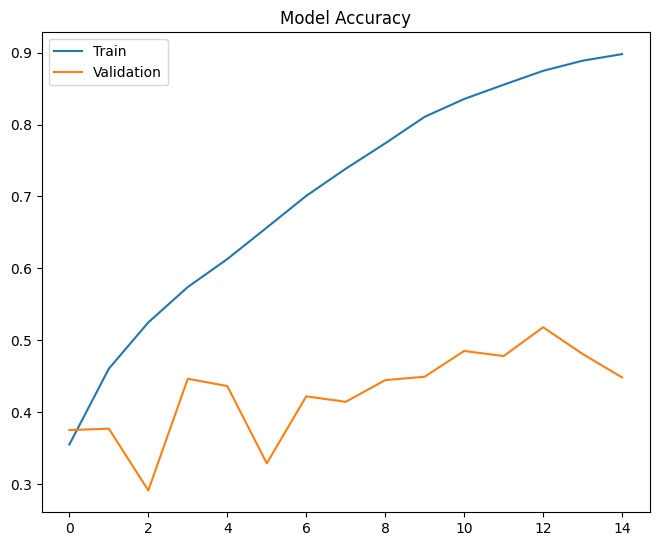

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train','Validation'],loc='upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0.0,hspace=0.25,wspace=0.35)

**Saving Model**

In [15]:
model_json=model.to_json()
with open("model_a.json","w") as json_file:
    json_file.write(model_json)